In [93]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, decimate

In [94]:
# ===== SESSION SELECTION =====
SESSION = "a3"         # animal id
STIM = "brush_ipsi"  # stim type
# =============================


# Load table (prefer local override if present)
table_path = Path("data/sessions.csv")
sessions = pd.read_csv(table_path, sep=',')  # your CSV is comma-delimited


# Select row by session + stim
row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())]
if row.empty:
    raise ValueError(f"No row found for session={SESSION}, stim={STIM}")


row = row.iloc[0]


# Extract paths and metadata
phy_dir = Path(row['phy_dir'])
lfp_dir  = Path(row['lfp_dir'])
age = str(row['age']).strip()
notes = str(row['notes']).strip()


# Anatomy bands
S1_upper_um  = float(row['s1_upper_um'])
S1_lower_um  = float(row['s1_lower_um'])
VPL_upper_um = float(row['vpl_upper_um'])
VPL_lower_um = float(row['vpl_lower_um'])

# Insertion depth 
tip_dv_mm = float(row['tip_dv_mm'])

# Constants
BANK_SPAN_MM = 3.84  # Neuropixels 1.0 recording bank span

# Sanity check
if phy_dir is None or not phy_dir.exists():
    print(f"⚠️ Warning: phy_dir not found or empty for {SESSION}/{STIM}. Check paths or notes: '{notes}'")
if lfp_dir is None or not lfp_dir.exists():
    print(f"⚠️ Warning: lfp_dir not found or empty for {SESSION}/{STIM}. Check paths.")


print(f"Loaded: {SESSION} / {STIM} (age: {age})")
print(f"Notes: {notes}")
print(f"phy_dir: {phy_dir}")
print(f"lfp_dir:  {lfp_dir}")


Loaded: a3 / brush_ipsi (age: adult)
Notes: Sprase
phy_dir: C:\Users\Ben\Desktop\Ipsi Brush\A3
lfp_dir:  E:\Neurpixels_Sally\practice3_SZMB_ipsibrush_final_2024-11-21_15-50-28\Record Node 118\experiment1\recording1\continuous\Neuropix-PXI-117.ProbeA-LFP


In [95]:
# Parameters
t0, twin = 0.0, None  # Time window in seconds
max_ch = None   # set to an int (e.g., 192) to cap plotted channels
bp_lo, bp_hi = 1, 300
gain = 10     # LFP gain per channel (adjust as needed)



Bank span: 3.84 mm
Top of bank: 0.18 mm DV
Tip (deepest site): 4.00 mm DV
Channels in brain: 383/383
Channels above surface: 0/383

✓ Saved: results\figures\a3_brush_ipsi_allchannel_lfp_26.2s.png


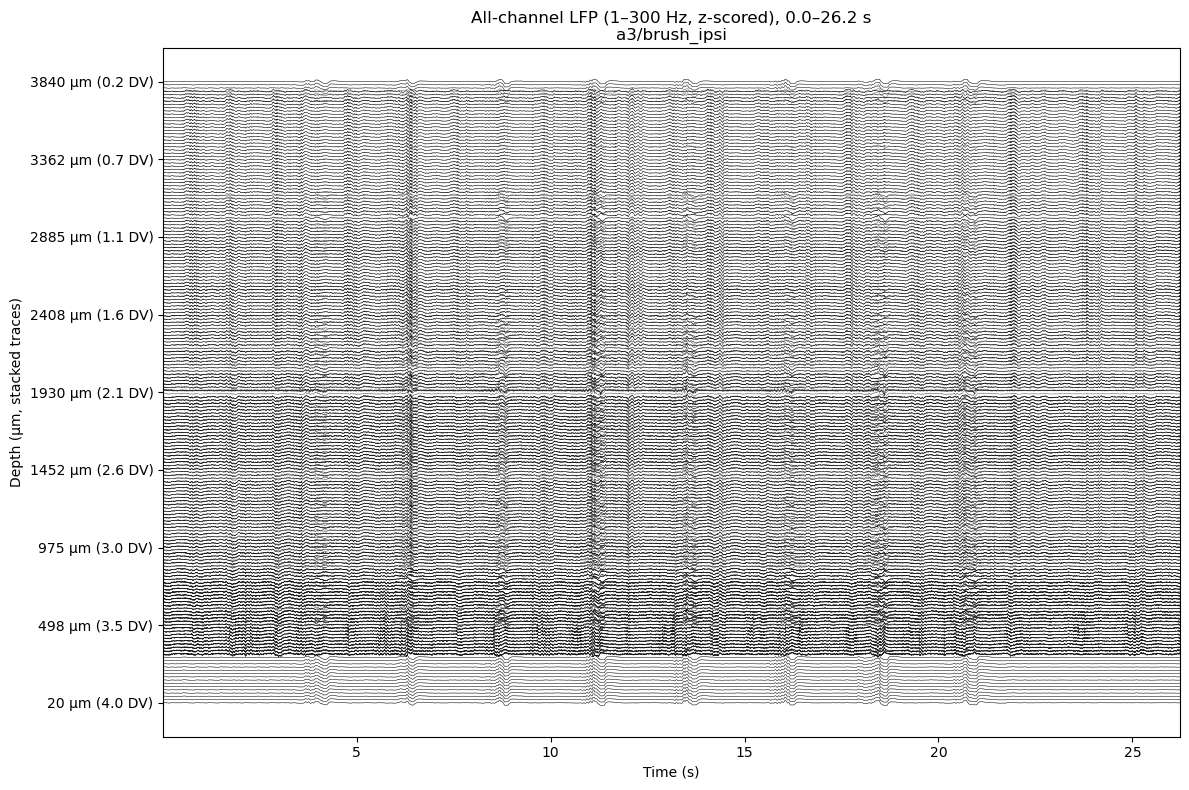

In [96]:
# %%
# ---- Get spike zero for clock anchoring ----
spike_times = np.load(phy_dir/'spike_times.npy')
spike_fs = 30000.0
try:
    txt = (phy_dir/'params.py').read_text()
    for line in txt.splitlines():
        if 'sample_rate' in line and '=' in line:
            spike_fs = float(line.split('=')[-1]); break
except Exception:
    pass
spike_zero = float(spike_times.min()/spike_fs)


# ---- Load channel positions and compute DV coordinates ----
chan_pos = np.load(phy_dir/'channel_positions.npy')  # (n_channels, 2)
depths_um = chan_pos[:,1]  # relative depth along probe in µm

# Compute absolute DV per channel if tip_dv_mm is available
if tip_dv_mm is not None:
    # Tip is at the LOWEST depth value (e.g., 20 µm), not the highest
    min_depth_um = np.min(depths_um)
    
    # Convert each channel's relative position to absolute DV
    # Tip is at min_depth_um, so:
    # DV = tip_dv_mm - (depth_um - min_depth_um) / 1000
    # This means channels higher up the shank (larger depth_um) have SMALLER DV
    dv_channels_mm = tip_dv_mm - (depths_um - min_depth_um) / 1000.0
    
    # Flag channels inside brain (DV >= 0)
    in_brain = dv_channels_mm >= 0.0
    
    # Compute bank range
    max_depth_um = np.max(depths_um)
    actual_span_mm = (max_depth_um - min_depth_um) / 1000.0
    top_bank_dv_mm = tip_dv_mm - actual_span_mm
    
    print(f"\nBank span: {BANK_SPAN_MM:.2f} mm")
    print(f"Top of bank: {top_bank_dv_mm:.2f} mm DV")
    print(f"Tip (deepest site): {tip_dv_mm:.2f} mm DV")
    print(f"Channels in brain: {np.sum(in_brain)}/{len(in_brain)}")
    print(f"Channels above surface: {np.sum(~in_brain)}/{len(in_brain)}")
else:
    dv_channels_mm = None
    in_brain = np.ones(len(depths_um), dtype=bool)  # assume all in brain if no tip info


# ---- Load LFP data directly ----
# Find the LFP continuous.dat file
lfp_file = lfp_dir / 'continuous.dat'
if not lfp_file.exists():
    raise FileNotFoundError(f"LFP file not found: {lfp_file}")


# LFP parameters
fs_lfp = 2500.0     # LFP sampling rate (Hz)
dtype_lfp = np.int16
n_channels = 384    # Neuropixels v1.0


# Calculate time window
if twin is None:
    # Load full file
    total_bytes = lfp_file.stat().st_size
    total_samples = total_bytes // (n_channels * 2)  # int16 = 2 bytes
    samples_start = int(t0 * fs_lfp)
    n_samples = total_samples - samples_start
else:
    t1 = t0 + twin
    samples_start = int(t0 * fs_lfp)
    n_samples = int(twin * fs_lfp)


# Load LFP data via memmap
byte_offset = samples_start * n_channels * np.dtype(dtype_lfp).itemsize
mm_lfp = np.memmap(lfp_file, dtype=dtype_lfp, mode='r', offset=byte_offset)
data_lfp = mm_lfp[:n_samples * n_channels]
lfp = data_lfp.reshape(-1, n_channels).astype('float32')  # shape: (time, channels)


# Create time vector aligned to spike clock
t_lfp = np.arange(lfp.shape[0]) / fs_lfp + t0
# Align to spike zero (LFP starts at same hardware clock as spikes)
t_lfp += spike_zero


# ---- Pick channels and ordering by depth ----
order = np.argsort(depths_um)  # shallow -> deep

if max_ch is not None:
    # subsample channels uniformly by depth if too many
    step = max(1, len(order)//max_ch)
    order = order[::step]


# Select channels in depth order
X = lfp[:, order]
t = t_lfp
depths_sel = depths_um[order]
in_brain_sel = in_brain[order] if dv_channels_mm is not None else np.ones(len(order), dtype=bool)
dv_sel = dv_channels_mm[order] if dv_channels_mm is not None else None


# ---- Display band-pass and z-score per channel ----
def bandpass(x, fs, lo=bp_lo, hi=bp_hi, order=3):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)


try:
    Xb = bandpass(X, fs_lfp, bp_lo, bp_hi, order=3)
except Exception:
    Xb = X


def zscore2D(M):
    m = np.median(M, axis=0, keepdims=True)
    s = np.std(M, axis=0, keepdims=True)
    s[s==0] = 1.0
    return (M - m) / s

Z = zscore2D(Xb)


# ---- Stack and plot: offset by depth (µm) to make a depth map ----
# normalize depth range to a neat spacing
dmin, dmax = float(np.nanmin(depths_sel)), float(np.nanmax(depths_sel))
depth_norm = (depths_sel - dmin) / max(1.0, (dmax - dmin))
offsets = depth_norm * 10000.0    # vertical span for all channels                   
Y = Z * gain + offsets  # stacked signals


# Plot with biological/non-biological highlighting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot biological channels in black, non-biological in red
for i in range(Y.shape[1]):
    color = 'black' if in_brain_sel[i] else 'red'
    alpha = 0.7 if in_brain_sel[i] else 0.3
    ax.plot(t, Y[:, i], color=color, linewidth=0.3, alpha=alpha)

ax.set_xlim(t[0], t[-1])

# Y-axis labels: show both relative µm and absolute DV (if available)
n_yticks = 9  # adjust how many ticks you want
if offsets.size == 0:
    yticks_pos = []
else:
    yticks_pos = np.linspace(float(offsets.min()), float(offsets.max()), n_yticks)

# Map offsets back to depths (µm)
# offsets = ((depths_sel - dmin) / (dmax - dmin)) * vertical_span
vertical_span = float(offsets.max() - offsets.min()) if offsets.max() != offsets.min() else 1.0
depths_ticks = dmin + ( (yticks_pos - offsets.min()) / vertical_span ) * (dmax - dmin)

if dv_sel is not None:
    # interpolate DV values at the tick offsets
    dv_ticks = np.interp(yticks_pos, offsets, dv_sel)
    yticks_lab = [f"{int(np.round(d))} µm ({dv:.1f} DV)" for d, dv in zip(depths_ticks, dv_ticks)]
else:
    yticks_lab = [f"{int(np.round(d))} µm" for d in depths_ticks]

ax.set_yticks(yticks_pos)
ax.set_yticklabels(yticks_lab)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Depth (µm, stacked traces)")

title_str = f"All-channel LFP ({bp_lo}–{bp_hi} Hz, z-scored), {t[0]:.1f}–{t[-1]:.1f} s"
if dv_channels_mm is not None:
    title_str += f"\n{SESSION}/{STIM}"
ax.set_title(title_str)
plt.tight_layout()


# ---- Save figure to results folder ----
out_dir = Path("results/figures")
out_dir.mkdir(parents=True, exist_ok=True)

# Build descriptive filename
filename = f"{SESSION}_{STIM}_allchannel_lfp_{t[-1]:.1f}s.png"
out_path = out_dir / filename

plt.savefig(out_path, dpi=200, bbox_inches="tight")
print(f"\n✓ Saved: {out_path}")

plt.show()


Bank span: 3.84 mm
Top of bank: 0.18 mm DV
Tip (deepest site): 4.00 mm DV
Channels in brain: 383/383
Channels above surface: 0/383
Channel filtering summary:
  - Excluded 30 broken channels (0-29)
  - Excluded 0 out-of-brain channels
  - Final count: 353 channels used

✓ Saved: results\figures\a3_brush_ipsi_goodchannel_lfp_26.2s.png


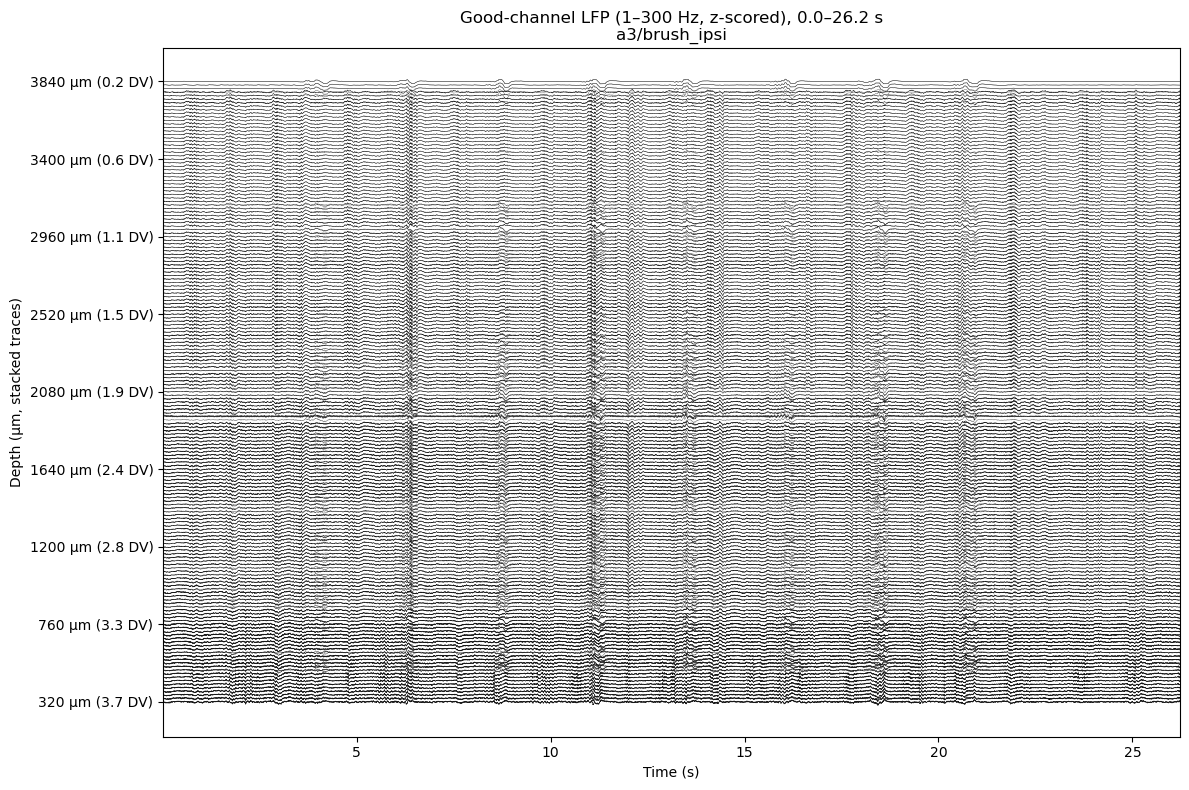

In [97]:
# %%
# ---- Get spike zero for clock anchoring ----
spike_times = np.load(phy_dir/'spike_times.npy')
spike_fs = 30000.0
try:
    txt = (phy_dir/'params.py').read_text()
    for line in txt.splitlines():
        if 'sample_rate' in line and '=' in line:
            spike_fs = float(line.split('=')[-1]); break
except Exception:
    pass
spike_zero = float(spike_times.min()/spike_fs)


# ---- Load channel positions and compute DV coordinates ----
chan_pos = np.load(phy_dir/'channel_positions.npy')  # (n_channels, 2)
depths_um = chan_pos[:,1]  # relative depth along probe in µm

# Compute absolute DV per channel if tip_dv_mm is available
if tip_dv_mm is not None:
    # Tip is at the LOWEST depth value (e.g., 20 µm), not the highest
    min_depth_um = np.min(depths_um)
    
    # Convert each channel's relative position to absolute DV
    # Tip is at min_depth_um, so:
    # DV = tip_dv_mm - (depth_um - min_depth_um) / 1000
    # This means channels higher up the shank (larger depth_um) have SMALLER DV
    dv_channels_mm = tip_dv_mm - (depths_um - min_depth_um) / 1000.0
    
    # Flag channels inside brain (DV >= 0)
    in_brain = dv_channels_mm >= 0.0
    
    # Compute bank range
    max_depth_um = np.max(depths_um)
    actual_span_mm = (max_depth_um - min_depth_um) / 1000.0
    top_bank_dv_mm = tip_dv_mm - actual_span_mm
    
    print(f"\nBank span: {BANK_SPAN_MM:.2f} mm")
    print(f"Top of bank: {top_bank_dv_mm:.2f} mm DV")
    print(f"Tip (deepest site): {tip_dv_mm:.2f} mm DV")
    print(f"Channels in brain: {np.sum(in_brain)}/{len(in_brain)}")
    print(f"Channels above surface: {np.sum(~in_brain)}/{len(in_brain)}")
else:
    dv_channels_mm = None
    in_brain = np.ones(len(depths_um), dtype=bool)  # assume all in brain if no tip info


# ---- Load LFP data directly ----
# Find the LFP continuous.dat file
lfp_file = lfp_dir / 'continuous.dat'
if not lfp_file.exists():
    raise FileNotFoundError(f"LFP file not found: {lfp_file}")


# LFP parameters
fs_lfp = 2500.0     # LFP sampling rate (Hz)
dtype_lfp = np.int16
n_channels = 384    # Neuropixels v1.0


# Calculate time window
if twin is None:
    # Load full file
    total_bytes = lfp_file.stat().st_size
    total_samples = total_bytes // (n_channels * 2)  # int16 = 2 bytes
    samples_start = int(t0 * fs_lfp)
    n_samples = total_samples - samples_start
else:
    t1 = t0 + twin
    samples_start = int(t0 * fs_lfp)
    n_samples = int(twin * fs_lfp)


# Load LFP data via memmap
byte_offset = samples_start * n_channels * np.dtype(dtype_lfp).itemsize
mm_lfp = np.memmap(lfp_file, dtype=dtype_lfp, mode='r', offset=byte_offset)
data_lfp = mm_lfp[:n_samples * n_channels]
lfp = data_lfp.reshape(-1, n_channels).astype('float32')  # shape: (time, channels)


# Create time vector aligned to spike clock
t_lfp = np.arange(lfp.shape[0]) / fs_lfp + t0
# Align to spike zero (LFP starts at same hardware clock as spikes)
t_lfp += spike_zero


# ---- Pick channels and ordering by depth ----
order = np.argsort(depths_um)  # shallow -> deep

# 1. Identify broken channels (0-29 are the deepest/broken ones)
bad_channels = np.arange(0, 30)
is_working = ~np.isin(order, bad_channels)

# 2. Identify channels inside the brain
# 'in_brain' is a boolean array indexed by channel ID (0-383).
# We look up the status for each channel currently in 'order'.
is_tissue = in_brain[order]

# 3. Combine filters: Keep channel ONLY if it is working AND in tissue
mask_keep = is_working & is_tissue

# Apply the filter
order = order[mask_keep]

print(f"Channel filtering summary:")
print(f"  - Excluded {np.sum(~is_working)} broken channels (0-29)")
print(f"  - Excluded {np.sum(~is_tissue)} out-of-brain channels")
print(f"  - Final count: {len(order)} channels used")

if max_ch is not None:
    # subsample channels uniformly by depth if too many
    step = max(1, len(order)//max_ch)
    order = order[::step]


# Select channels in depth order
X = lfp[:, order]
t = t_lfp
depths_sel = depths_um[order]
in_brain_sel = in_brain[order] if dv_channels_mm is not None else np.ones(len(order), dtype=bool)
dv_sel = dv_channels_mm[order] if dv_channels_mm is not None else None


# ---- Display band-pass and z-score per channel ----
def bandpass(x, fs, lo=bp_lo, hi=bp_hi, order=3):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)


try:
    Xb = bandpass(X, fs_lfp, bp_lo, bp_hi, order=3)
except Exception:
    Xb = X


def zscore2D(M):
    m = np.median(M, axis=0, keepdims=True)
    s = np.std(M, axis=0, keepdims=True)
    s[s==0] = 1.0
    return (M - m) / s

Z = zscore2D(Xb)


# ---- Stack and plot: offset by depth (µm) to make a depth map ----
# normalize depth range to a neat spacing
dmin, dmax = float(np.nanmin(depths_sel)), float(np.nanmax(depths_sel))
depth_norm = (depths_sel - dmin) / max(1.0, (dmax - dmin))
offsets = depth_norm * 10000.0    # vertical span for all channels                   
Y = Z * gain + offsets  # stacked signals


# Plot with biological/non-biological highlighting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot biological channels in black, non-biological in red
for i in range(Y.shape[1]):
    color = 'black' if in_brain_sel[i] else 'red'
    alpha = 0.7 if in_brain_sel[i] else 0.3
    ax.plot(t, Y[:, i], color=color, linewidth=0.3, alpha=alpha)

ax.set_xlim(t[0], t[-1])

# Y-axis labels: show both relative µm and absolute DV (if available)
n_yticks = 9  # adjust how many ticks you want
if offsets.size == 0:
    yticks_pos = []
else:
    yticks_pos = np.linspace(float(offsets.min()), float(offsets.max()), n_yticks)

# Map offsets back to depths (µm)
# offsets = ((depths_sel - dmin) / (dmax - dmin)) * vertical_span
vertical_span = float(offsets.max() - offsets.min()) if offsets.max() != offsets.min() else 1.0
depths_ticks = dmin + ( (yticks_pos - offsets.min()) / vertical_span ) * (dmax - dmin)

if dv_sel is not None:
    # interpolate DV values at the tick offsets
    dv_ticks = np.interp(yticks_pos, offsets, dv_sel)
    yticks_lab = [f"{int(np.round(d))} µm ({dv:.1f} DV)" for d, dv in zip(depths_ticks, dv_ticks)]
else:
    yticks_lab = [f"{int(np.round(d))} µm" for d in depths_ticks]

ax.set_yticks(yticks_pos)
ax.set_yticklabels(yticks_lab)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Depth (µm, stacked traces)")

title_str = f"Good-channel LFP ({bp_lo}–{bp_hi} Hz, z-scored), {t[0]:.1f}–{t[-1]:.1f} s"
if dv_channels_mm is not None:
    title_str += f"\n{SESSION}/{STIM}"
ax.set_title(title_str)
plt.tight_layout()


# ---- Save figure to results folder ----
out_dir = Path("results/figures")
out_dir.mkdir(parents=True, exist_ok=True)

# Build descriptive filename
filename = f"{SESSION}_{STIM}_goodchannel_lfp_{t[-1]:.1f}s.png"
out_path = out_dir / filename

plt.savefig(out_path, dpi=200, bbox_inches="tight")
print(f"\n✓ Saved: {out_path}")

plt.show()

✓ Saved: results\figures\INSPECTION_a3_brush_ipsi_ch374-382.png


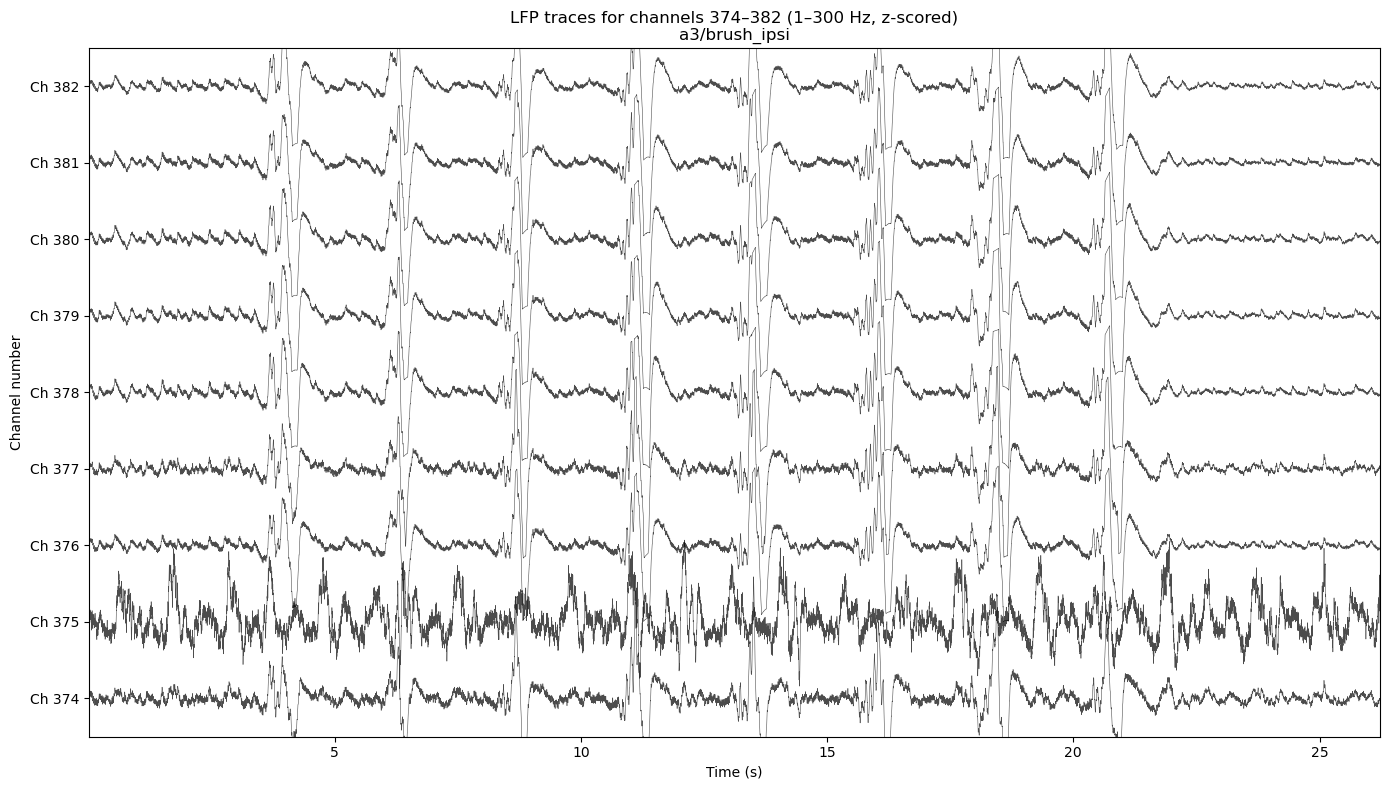

Channel 191: 1940.0 µm


In [98]:
# ---- Specify the channel range you want to inspect ----
ch_start = 374
ch_end = 382

# Select channels in this range
ch_range = np.arange(ch_start, ch_end + 1)
ch_range = ch_range[ch_range < lfp.shape[1]]  # Don't exceed available channels

# Get LFP data for these channels
X_subset = lfp[:, ch_range]
depths_subset = depths_um[ch_range]

# Optional: apply bandpass and z-score (same as your all-channel plotter)
from scipy.signal import butter, filtfilt

def bandpass(x, fs, lo=1, hi=300, order=3):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)

def zscore2D(M):
    m = np.median(M, axis=0, keepdims=True)
    s = np.std(M, axis=0, keepdims=True)
    s[s==0] = 1.0
    return (M - m) / s

Xb = bandpass(X_subset, fs_lfp, lo=1, hi=300, order=3)
Z = zscore2D(Xb)

# Stack traces with vertical offsets
gain = 50  # Adjust this to control trace amplitude
offsets = np.arange(len(ch_range)) * 200  # 200 µm spacing between traces
Y = Z * gain + offsets

# Create time vector
t = np.arange(lfp.shape[0]) / fs_lfp + spike_zero

# ---- Plot ----
fig, ax = plt.subplots(figsize=(14, 8))

for i, ch_idx in enumerate(ch_range):
    ax.plot(t, Y[:, i], color='black', linewidth=0.4, alpha=0.7)

# Set y-axis to show channel numbers
ax.set_yticks(offsets)
ax.set_yticklabels([f"Ch {ch}" for ch in ch_range])
ax.set_ylim(offsets[0] - 100, offsets[-1] + 100)

ax.set_xlim(t[0], t[-1])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Channel number")
ax.set_title(f"LFP traces for channels {ch_start}–{ch_end} (1–300 Hz, z-scored)\n{SESSION}/{STIM}")

plt.tight_layout()

# Save
out_dir = Path("results/figures")
out_dir.mkdir(parents=True, exist_ok=True)
filename = f"INSPECTION_{SESSION}_{STIM}_ch{ch_start}-{ch_end}.png"
plt.savefig(out_dir / filename, dpi=200, bbox_inches="tight")
print(f"✓ Saved: {out_dir / filename}")

plt.show()

# Print depth of a specific channel (e.g., channel 25)
ch = 191
print(f"Channel {ch}: {depths_um[ch]:.1f} µm")



cluster_info.tsv not found.
Plotting 25 units (Good + MUA)


<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Ben\AppData\Local\Temp\ipykernel_31748\1578803044.py:25: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Depth ($\mu$m)")


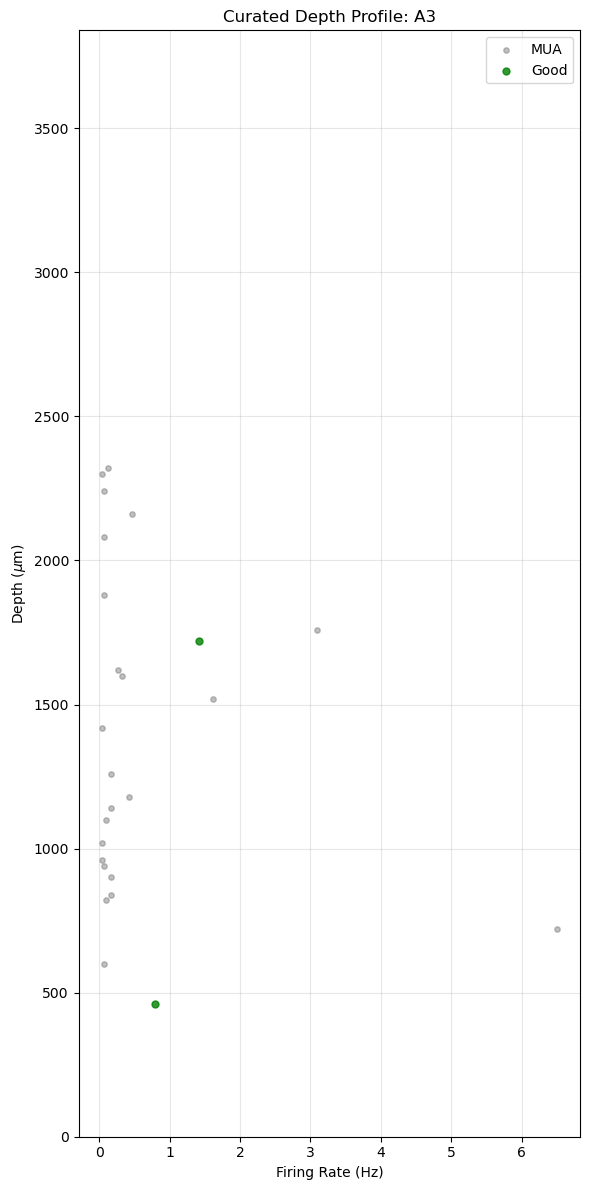

In [99]:
# 2. Load Curation Labels (Handle missing cluster_info.tsv)
try:
    # Try loading the full info file first
    cluster_stats = pd.read_csv(phy_dir / 'cluster_info.tsv', sep='\t')
    print("Loaded cluster_info.tsv")
except FileNotFoundError:
    print("cluster_info.tsv not found.")

# 3. Filter for "Good" and "MUA"
valid_units = cluster_stats[cluster_stats['group'].isin(['good', 'mua'])]

print(f"Plotting {len(valid_units)} units (Good + MUA)")

# 4. Plot Depth Profile
plt.figure(figsize=(6, 12))

# Separate for coloring
good = valid_units[valid_units['group'] == 'good']
mua = valid_units[valid_units['group'] == 'mua']

plt.scatter(mua['fr'], mua['depth'], c='gray', alpha=0.5, s=15, label='MUA')
plt.scatter(good['fr'], good['depth'], c='green', alpha=0.8, s=25, label='Good')

# Formatting
plt.ylabel("Depth ($\mu$m)")
plt.xlabel("Firing Rate (Hz)")
plt.title(f"Curated Depth Profile: {phy_dir.name}")
plt.legend()
plt.grid(True, alpha=0.3)

plt.ylim(0, np.max(chan_pos[:,1]))  # Deep (tip) at bottom, surface at top

plt.tight_layout()
plt.show()



--- DETECTED 8 STIMULI ---


ValueError: fp and xp are not of the same length.

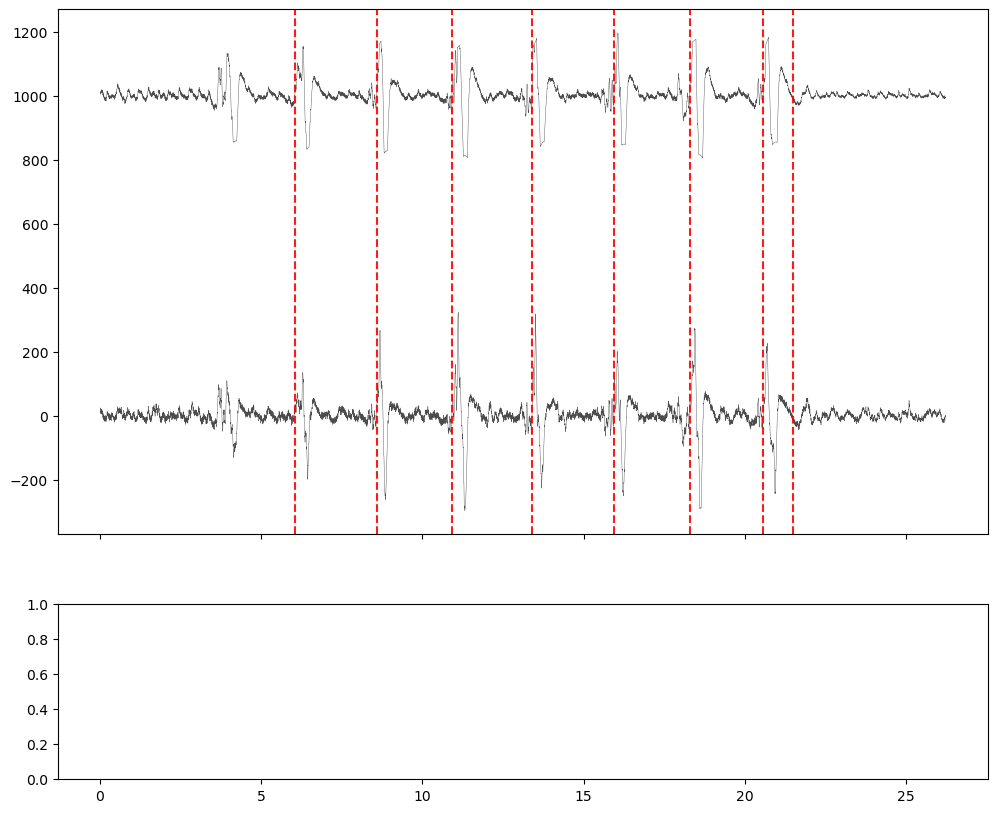

In [101]:
# =========================================================
# Stim Onset Detection
# =========================================================
from scipy.signal import find_peaks, peak_widths

# 1. Calculate Global Energy
detection_trace = np.mean(np.abs(Z), axis=1) 

# 2. Find Peaks
peaks, _ = find_peaks(detection_trace, height=1, distance=1.0 * fs_lfp)

# 3. Find Onsets using Peak Geometry
widths, width_heights, left_ips, right_ips = peak_widths(detection_trace, peaks, rel_height=0.95)

# Convert to integer indices
onset_indices = np.floor(left_ips).astype(int)
stim_times = t[onset_indices]

# --- FIX 1: Remove the first event from ALL arrays ---
# If we only remove it from stim_times, the bottom plot (peaks/dots) will desync
if len(stim_times) > 0:
    stim_times = stim_times[1:]
    peaks = peaks[1:]
    onset_indices = onset_indices[1:]
    width_heights = width_heights[1:]
    # Also fix the width lines for plotting
    left_ips = left_ips[1:]
    right_ips = right_ips[1:]

print(f"\n--- DETECTED {len(stim_times)} STIMULI ---")

# =========================================================
# PLOT TO VERIFY
# =========================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# --- TOP PLOT: Stacked LFP ---
subset = np.arange(0, Y.shape[1], 5)
for i in subset:
    color = 'black' if in_brain_sel[i] else 'red'
    alpha = 0.7 if in_brain_sel[i] else 0.3
    ax1.plot(t, Y[:, i], color=color, linewidth=0.3, alpha=alpha)

# Add Red Dashed Lines at Onset times
for st in stim_times:
    ax1.axvline(st, color='red', linestyle='--', alpha=0.9, linewidth=1.5)

# --- FIX 2: Correct Depth Labels on Y-Axis ---
# We define ticks based on the 'offsets' used to create Y, mapping them to 'depths_sel'
# offsets are typically monotonic, so we can interpolate.
n_ticks = 10
# Create visual positions for ticks
tick_pos = np.linspace(offsets.min(), offsets.max(), n_ticks)
# Map these visual positions to actual microns
tick_labels_um = np.interp(tick_pos, offsets, depths_sel)

ax1.set_yticks(tick_pos)
# Format as integers
ax1.set_yticklabels([f"{int(d)} µm" for d in tick_labels_um])
ax1.set_ylabel("Depth (µm)")
ax1.set_title(f"Stimulus Onset")

# --- BOTTOM PLOT: Energy Trace ---
ax2.plot(t, detection_trace, color='blue', linewidth=1, label='Probe Energy')
ax2.plot(t[peaks], detection_trace[peaks], 'gx', label='Peak')
ax2.plot(stim_times, detection_trace[onset_indices], 'ro', label='Calculated Onset')

# Visualize the "width" calculation (Corrected to match sliced arrays)
# We reconstruct the x-time for the width lines based on the sliced 'left_ips' and 'right_ips'
# ax2.hlines(width_heights, t[np.floor(left_ips).astype(int)], t[np.floor(right_ips).astype(int)], 
           # color="orange", linestyle=":", label="Width @ 95%")

ax2.set_ylabel("Energy (Z-score)")
ax2.set_xlabel("Time (s)")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\n--- Detected Stimulus Times (Seconds) ---")
for t_val in stim_times:
    print(f"{t_val:.4f}") 

# --- OPTIONAL: SAVE ONSETS ---
if len(stim_times) > 0:
     np.savetxt(f"results/summaries/{SESSION}_{STIM}_onsets.txt", stim_times)

In [ ]:
# =========================================================
# STEP 1: LOAD THE ONSETS AND DEFINE PARAMETERS
# =========================================================
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the times we just saved
onset_file = f"results/summaries/{SESSION}_{STIM}_onsets.txt"
stim_times = np.loadtxt(onset_file)

# Define the Window of Interest (in seconds)
PRE_TIME = 0.5   # Seconds before onset
POST_TIME = 1.5  # Seconds after onset

# Convert to samples
n_pre = int(PRE_TIME * fs_lfp)
n_post = int(POST_TIME * fs_lfp)
total_pts = n_pre + n_post
time_axis = np.linspace(-PRE_TIME, POST_TIME, total_pts)

print(f"Loaded {len(stim_times)} events from {onset_file}")
print(f"Epoching window: -{PRE_TIME}s to +{POST_TIME}s")

# =========================================================
# STEP 2: EPOCHING (CUTTING THE DATA)
# =========================================================
# We need a 3D matrix: (Number of Trials) x (Number of Channels) x (Timepoints)
n_trials = len(stim_times)
n_chans = Z.shape[1]
epochs = np.zeros((n_trials, n_chans, total_pts))

valid_trials = []

for i, t_start in enumerate(stim_times):
    # Find the index of the onset
    idx_start = int(t_start * fs_lfp)
    
    # Define start and end indices
    idx_e_start = idx_start - n_pre
    idx_e_end = idx_start + n_post
    
    # Boundary Check: Ensure we don't try to read before start or after end of file
    if idx_e_start >= 0 and idx_e_end < Z.shape[0]:
        # Extract the chunk
        chunk = Z[idx_e_start:idx_e_end, :] # shape: (time, chans)
        
        # Transpose so it matches (chans, time) for easier plotting later
        epochs[i, :, :] = chunk.T 
        valid_trials.append(i)

# Filter out bad trials (edges)
epochs = epochs[valid_trials, :, :]
n_trials = len(valid_trials)

# =========================================================
# STEP 3: BASELINE CORRECTION
# =========================================================
# Calculate the mean of the pre-stim period (0 to n_pre) for each trial/channel
baseline = np.mean(epochs[:, :, :n_pre], axis=2, keepdims=True)
# Subtract baseline
epochs_bc = epochs - baseline

# Calculate the Grand Average (Mean across all trials)
# Shape becomes: (Channels, Time)
evoked_potential = np.mean(epochs_bc, axis=0)

# =========================================================
# STEP 4: PLOTTING
# =========================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [2, 1]})

# --- LEFT PLOT: DEPTH HEATMAP (Depth vs Time) ---
# We use 'extent' to map the array indices to actual Time and Depth
# extent = [x_min, x_max, y_min, y_max]
# Note: depths_sel[0] is usually the top (0) and [-1] is bottom (3840), 
# so we might need to flip the array or the axis depending on your probe map.
# Assuming column 0 is top of brain:

vm = np.percentile(np.abs(evoked_potential), 99) # Auto-scale color range

im1 = ax1.imshow(evoked_potential, 
                 aspect='auto', 
                 origin='upper', 
                 cmap='RdBu_r', # Red-Blue Reverse (Red=positive, Blue=negative)
                 vmin=-vm, vmax=vm,
                 extent=[-PRE_TIME, POST_TIME, depths_sel[-1], depths_sel[0]])

ax1.axvline(0, color='k', linestyle='--', linewidth=1) # The Stimulus Line
ax1.set_xlabel("Time from Stimulus (s)")
ax1.set_ylabel("Depth (µm)")
ax1.set_title(f"Average Response (n={n_trials})")
plt.colorbar(im1, ax=ax1, label="Z-Scored Voltage")


# --- RIGHT PLOT: TRIAL RASTER (Trials vs Time) ---
# We pick the channel with the HIGHEST response to show the consistency
# Find channel with max absolute deflection
best_chan_idx = np.argmax(np.max(np.abs(evoked_potential), axis=1))
best_depth = depths_sel[best_chan_idx]

# Extract that single channel across all trials
# Shape: (Trials, Time)
single_chan_data = epochs_bc[:, best_chan_idx, :]

im2 = ax2.imshow(single_chan_data,
                 aspect='auto',
                 origin='lower', # Trial 1 at bottom
                 cmap='viridis',
                 extent=[-PRE_TIME, POST_TIME, 0, n_trials])

ax2.axvline(0, color='w', linestyle='--', linewidth=1)
ax2.set_xlabel("Time from Stimulus (s)")
ax2.set_ylabel("Trial Number")
ax2.set_title(f"Trial Consistency @ {int(best_depth)}µm")
# plt.colorbar(im2, ax=ax2, label="Z-score")

plt.suptitle(f"Subject: {SESSION} | Stimulus: {STIM}", fontsize=16)
plt.tight_layout()
plt.show()

FileNotFoundError: results/summaries/a3_brush_ipsi_onsets.txt not found.